# Desafio de Previs√£o de Sucesso de Startups

## Objetivo
Desenvolver um modelo preditivo capaz de identificar quais startups apresentam maior probabilidade de se tornarem casos de sucesso no mercado.

## Sobre este Notebook
Este notebook documenta todo o processo de:
- Importa√ß√£o e explora√ß√£o dos dados
- Limpeza e tratamento de valores nulos
- Codifica√ß√£o de vari√°veis categ√≥ricas
- Engenharia de features
- Sele√ß√£o de features
- Constru√ß√£o e avalia√ß√£o do modelo
- Finetuning de hiperpar√¢metros
- Gera√ß√£o de predi√ß√µes para submiss√£o

## 1. Importa√ß√£o de Bibliotecas

Utilizaremos apenas as bibliotecas permitidas pelo campeonato:
- **Numpy**: Para opera√ß√µes matem√°ticas e num√©ricas
- **Pandas**: Para manipula√ß√£o e an√°lise de dados
- **Scikit-learn**: Para constru√ß√£o e avalia√ß√£o do modelo de machine learning

In [26]:
import pathlib
from typing import Tuple

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Bibliotecas de visualiza√ß√£o
import matplotlib.pyplot as plt
import seaborn as sns

# Configura√ß√µes de visualiza√ß√£o
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 2. Carregamento dos Dados

Vamos carregar os dados de treino e teste fornecidos pela competi√ß√£o.

In [27]:
# Definir caminhos dos arquivos
project_root = pathlib.Path().resolve()
train_csv = project_root / "train.csv"
test_csv = project_root / "test.csv"
submission_csv = project_root / "submission_1.csv"

# Carregar dados
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

print(f"Dimens√µes do conjunto de treino: {train_df.shape}")
print(f"Dimens√µes do conjunto de teste: {test_df.shape}")

Dimens√µes do conjunto de treino: (646, 33)
Dimens√µes do conjunto de teste: (277, 32)


## 3. Explora√ß√£o e Visualiza√ß√£o dos Dados

### 3.1 Vis√£o Geral dos Dados

In [28]:
# Visualizar primeiras linhas do dataset de treino
print("Primeiras linhas do dataset de treino:")
display(train_df.head())

# Informa√ß√µes sobre os tipos de dados e valores nulos
print("\nInforma√ß√µes sobre o dataset:")
train_df.info()

Primeiras linhas do dataset de treino:


id  age_first_funding_year  age_last_funding_year  \
0  719                   10.42                  13.09   
1  429                    3.79                   3.79   
2  178                    0.71                   2.28   
3  197                    3.00                   5.00   
4  444                    0.66                   5.88   

   age_first_milestone_year  age_last_milestone_year  relationships  \
0                      8.98                    12.72              4   
1                       NaN                      NaN             21   
2                      1.95                     2.28              5   
3                      9.62                    10.39             16   
4                      6.21                     8.61             29   

   funding_rounds  funding_total_usd  milestones  is_CA  ...  is_consulting  \
0               3            4087500           3      1  ...              0   
1               1           45000000           0      0  ...              0   
2               2            5200000           2      1  ...              0   
3               2           14500000           2      0  ...              0   
4               5           70000000           4      1  ...              0   

   is_othercategory  has_VC  has_angel has_roundA  has_roundB  has_roundC  \
0                 0       1          1          0           0           0   
1                 0       0          0          0           1           0   
2                 1       1          0          1           0           0   
3                 0       0          1          0           1           0   
4                 0       0          0          1           1           1   

   has_roundD  avg_participants  labels  
0           0               1.0       0  
1           0               1.0       1  
2           0               1.0       0  
3           0               2.0       1  
4           1               2.8       1  

[5 rows x 33 columns]


Informa√ß√µes sobre o dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        646 non-null    int64  
 1   age_first_funding_year    611 non-null    float64
 2   age_last_funding_year     637 non-null    float64
 3   age_first_milestone_year  508 non-null    float64
 4   age_last_milestone_year   535 non-null    float64
 5   relationships             646 non-null    int64  
 6   funding_rounds            646 non-null    int64  
 7   funding_total_usd         646 non-null    int64  
 8   milestones                646 non-null    int64  
 9   is_CA                     646 non-null    int64  
 10  is_NY                     646 non-null    int64  
 11  is_MA                     646 non-null    int64  
 12  is_TX                     646 non-null    int64  
 13  is_otherstate             646 non

In [29]:
# Estat√≠sticas descritivas das vari√°veis num√©ricas
print("Estat√≠sticas descritivas:")
display(train_df.describe())

Estat√≠sticas descritivas:


id  age_first_funding_year  age_last_funding_year  \
count  646.000000              611.000000             637.000000   
mean   461.577399                2.341718               4.037724   
std    264.859464                2.468275               2.950923   
min      1.000000                0.000000               0.000000   
25%    233.250000                0.680000               1.870000   
50%    459.500000                1.650000               3.610000   
75%    692.500000                3.600000               5.590000   
max    923.000000               21.900000              21.900000   

       age_first_milestone_year  age_last_milestone_year  relationships  \
count                508.000000               535.000000     646.000000   
mean                   3.352657                 4.944729       7.948916   
std                    2.866952                 3.213319       7.397602   
min                    0.000000                 0.000000       0.000000   
25%                    1.185000                 2.540000       3.000000   
50%                    2.785000                 4.620000       6.000000   
75%                    4.935000                 6.880000      10.000000   
max                   24.680000                24.680000      63.000000   

       funding_rounds  funding_total_usd  milestones       is_CA  ...  \
count      646.000000       6.460000e+02  646.000000  646.000000  ...   
mean         2.351393       2.949633e+07    1.913313    0.546440  ...   
std          1.357856       2.261999e+08    1.337095    0.498224  ...   
min          1.000000       1.100000e+04    0.000000    0.000000  ...   
25%          1.000000       3.000000e+06    1.000000    0.000000  ...   
50%          2.000000       1.020000e+07    2.000000    1.000000  ...   
75%          3.000000       2.587500e+07    3.000000    1.000000  ...   
max          8.000000       5.700000e+09    6.000000    1.000000  ...   

       is_consulting  is_othercategory      has_VC   has_angel  has_roundA  \
count     646.000000        646.000000  646.000000  646.000000  646.000000   
mean        0.003096          0.304954    0.329721    0.260062    0.515480   
std         0.055598          0.460745    0.470476    0.439008    0.500148   
min         0.000000          0.000000    0.000000    0.000000    0.000000   
25%         0.000000          0.000000    0.000000    0.000000    0.000000   
50%         0.000000          0.000000    0.000000    0.000000    1.000000   
75%         0.000000          1.000000    1.000000    1.000000    1.000000   
max         1.000000          1.000000    1.000000    1.000000    1.000000   

       has_roundB  has_roundC  has_roundD  avg_participants      labels  
count  646.000000  646.000000  646.000000        646.000000  646.000000  
mean     0.419505    0.235294    0.091331          2.848655    0.647059  
std      0.493860    0.424511    0.288303          1.894050    0.478255  
min      0.000000    0.000000    0.000000          1.000000    0.000000  
25%      0.000000    0.000000    0.000000          1.500000    0.000000  
50%      0.000000    0.000000    0.000000          2.333300    1.000000  
75%      1.000000    0.000000    0.000000          4.000000    1.000000  
max      1.000000    1.000000    1.000000         16.000000    1.000000  

[8 rows x 32 columns]

### 3.2 An√°lise de Valores Nulos

Identificar e quantificar valores ausentes √© crucial para o processo de limpeza dos dados.

In [30]:
# An√°lise de valores nulos
print("Valores nulos por coluna:")
missing_values = train_df.isnull().sum()
missing_percent = (missing_values / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Valores Nulos': missing_values,
    'Porcentagem (%)': missing_percent
})
display(missing_df[missing_df['Valores Nulos'] > 0].sort_values('Valores Nulos', ascending=False))

Valores nulos por coluna:


Valores Nulos  Porcentagem (%)
age_first_milestone_year            138        21.362229
age_last_milestone_year             111        17.182663
age_first_funding_year               35         5.417957
age_last_funding_year                 9         1.393189

### 3.3 Distribui√ß√£o da Vari√°vel Alvo

Analisar a distribui√ß√£o da vari√°vel alvo (labels) para verificar se h√° desbalanceamento entre as classes.

In [31]:
# Verificar distribui√ß√£o da vari√°vel alvo
print("Distribui√ß√£o da vari√°vel alvo (labels):")
print(train_df['labels'].value_counts())
print("\nPropor√ß√£o:")
print(train_df['labels'].value_counts(normalize=True))

Distribui√ß√£o da vari√°vel alvo (labels):
labels
1    418
0    228
Name: count, dtype: int64

Propor√ß√£o:
labels
1    0.647059
0    0.352941
Name: proportion, dtype: float64


### 3.4 Visualiza√ß√µes Gr√°ficas

Vamos criar visualiza√ß√µes para entender melhor a distribui√ß√£o dos dados e rela√ß√µes entre vari√°veis.

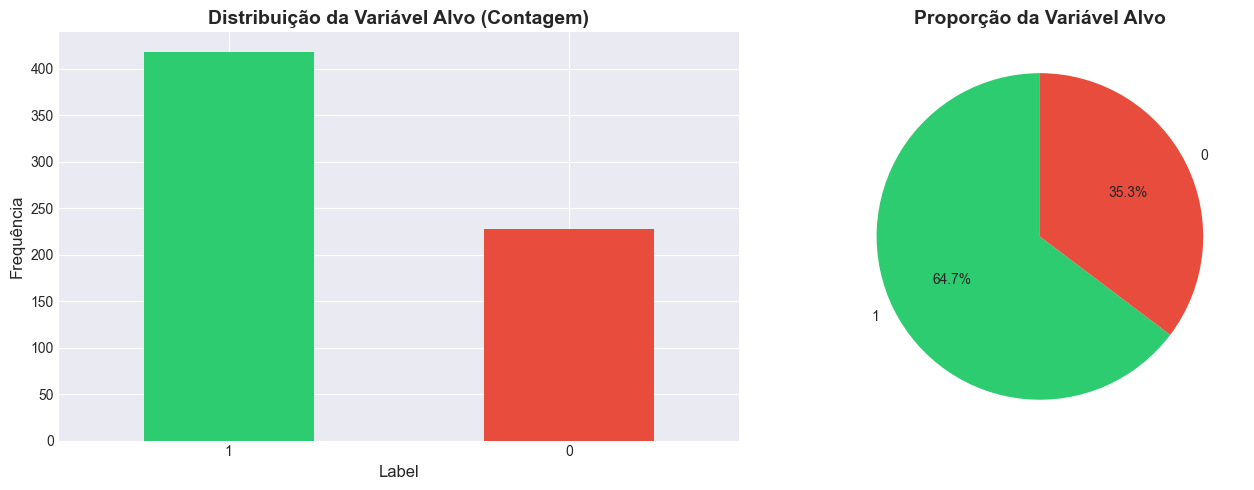


Observa√ß√£o: Verificamos se h√° desbalanceamento de classes que possa afetar o modelo.


In [32]:
# Visualiza√ß√£o da distribui√ß√£o da vari√°vel alvo
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Gr√°fico de barras
train_df['labels'].value_counts().plot(kind='bar', ax=ax[0], color=['#2ecc71', '#e74c3c'])
ax[0].set_title('Distribui√ß√£o da Vari√°vel Alvo (Contagem)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Label', fontsize=12)
ax[0].set_ylabel('Frequ√™ncia', fontsize=12)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)

# Gr√°fico de pizza
train_df['labels'].value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%', 
                                        colors=['#2ecc71', '#e74c3c'], startangle=90)
ax[1].set_title('Propor√ß√£o da Vari√°vel Alvo', fontsize=14, fontweight='bold')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

print("\nObserva√ß√£o: Verificamos se h√° desbalanceamento de classes que possa afetar o modelo.")

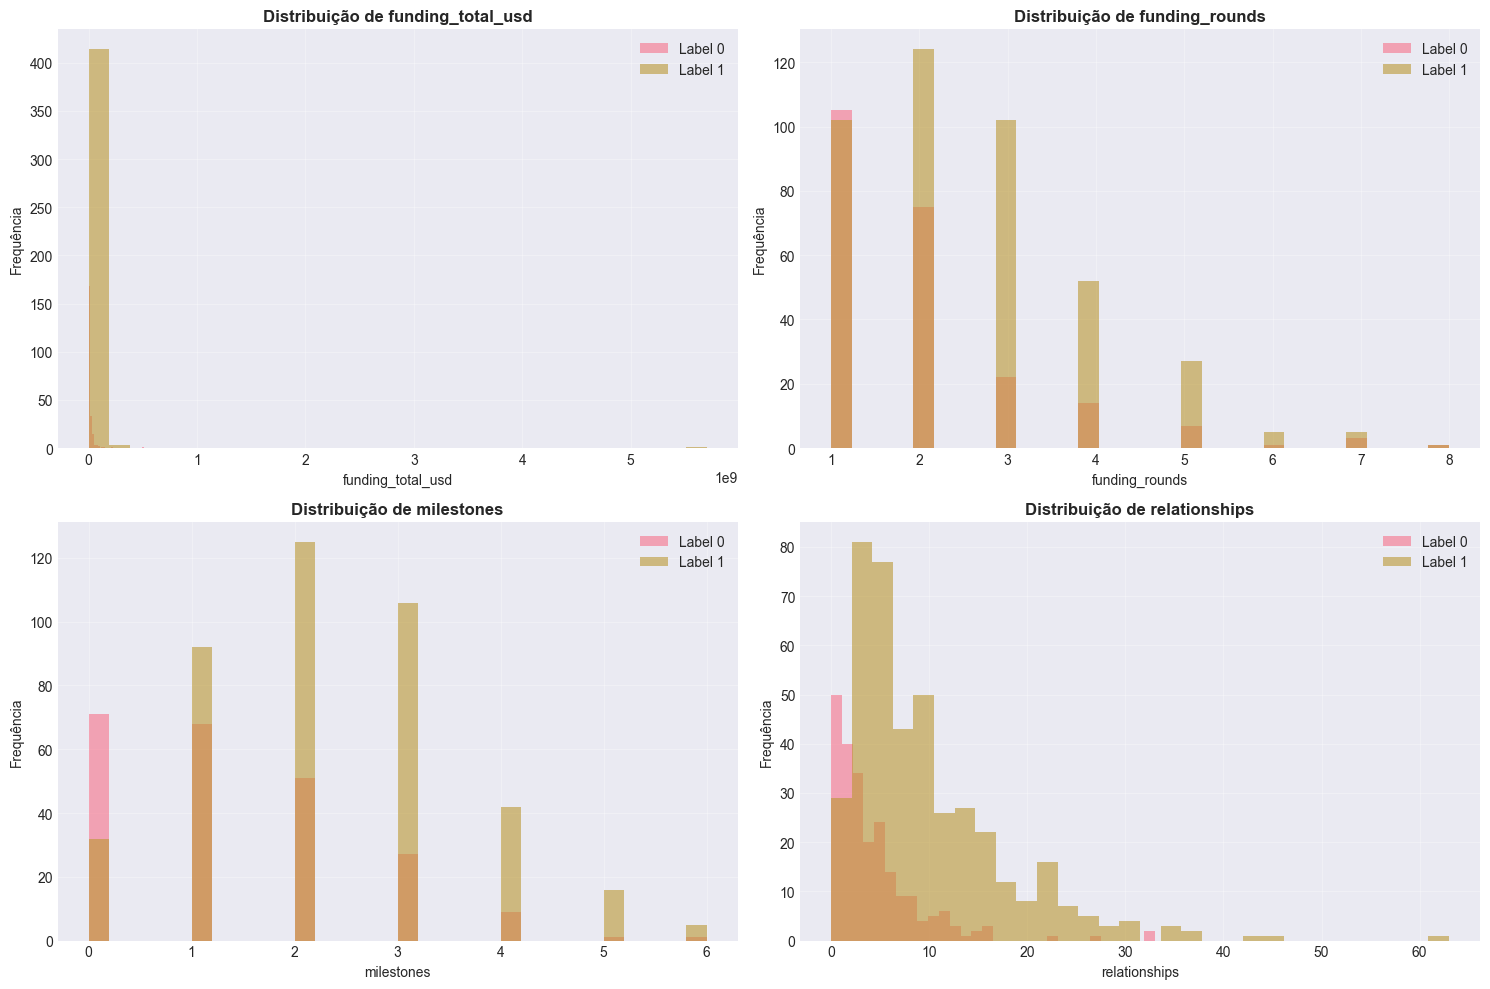

Observa√ß√£o: Analisamos como as vari√°veis num√©ricas se distribuem entre as classes.


In [33]:
# An√°lise das principais vari√°veis num√©ricas
numeric_cols = train_df.select_dtypes(include=['number']).columns.tolist()
if 'labels' in numeric_cols:
    numeric_cols.remove('labels')
if 'id' in numeric_cols:
    numeric_cols.remove('id')

# Selecionar as principais vari√°veis para visualiza√ß√£o
key_vars = ['funding_total_usd', 'funding_rounds', 'milestones', 'relationships']
available_vars = [var for var in key_vars if var in numeric_cols]

if len(available_vars) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(available_vars[:4]):
        for label in train_df['labels'].unique():
            data = train_df[train_df['labels'] == label][col].dropna()
            axes[idx].hist(data, bins=30, alpha=0.6, label=f'Label {label}')
        
        axes[idx].set_title(f'Distribui√ß√£o de {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col, fontsize=10)
        axes[idx].set_ylabel('Frequ√™ncia', fontsize=10)
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Observa√ß√£o: Analisamos como as vari√°veis num√©ricas se distribuem entre as classes.")

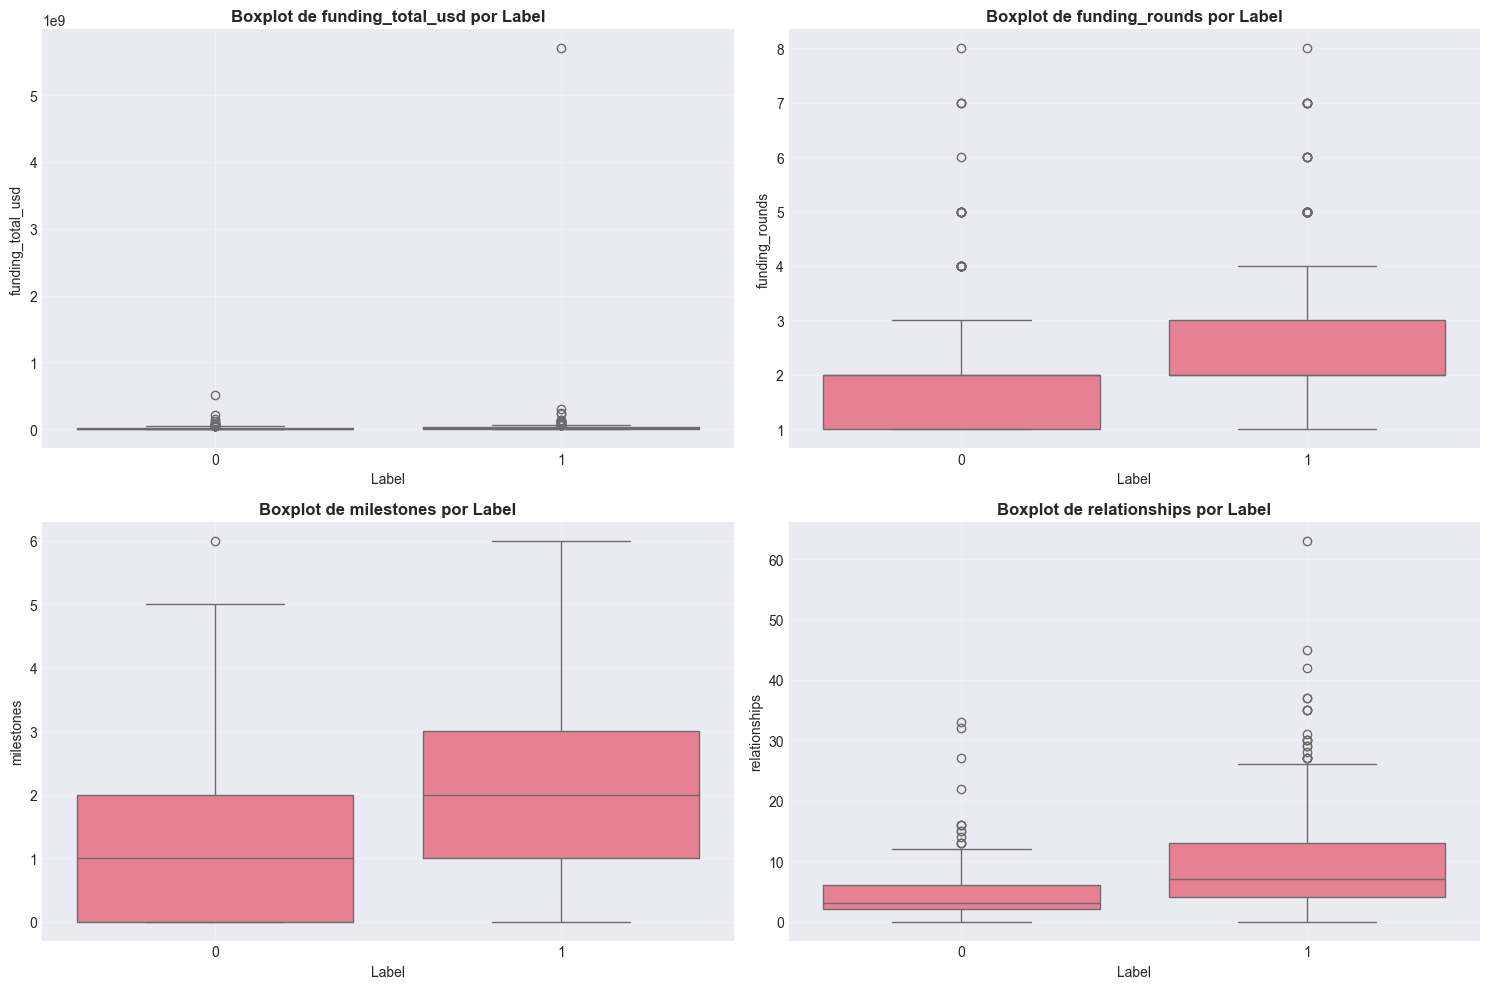

Observa√ß√£o: Boxplots ajudam a identificar outliers e diferen√ßas nas distribui√ß√µes entre classes.


In [34]:
# Boxplots para identificar outliers e diferen√ßas entre classes
if len(available_vars) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(available_vars[:4]):
        sns.boxplot(data=train_df, x='labels', y=col, ax=axes[idx])
        axes[idx].set_title(f'Boxplot de {col} por Label', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Label', fontsize=10)
        axes[idx].set_ylabel(col, fontsize=10)
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Observa√ß√£o: Boxplots ajudam a identificar outliers e diferen√ßas nas distribui√ß√µes entre classes.")

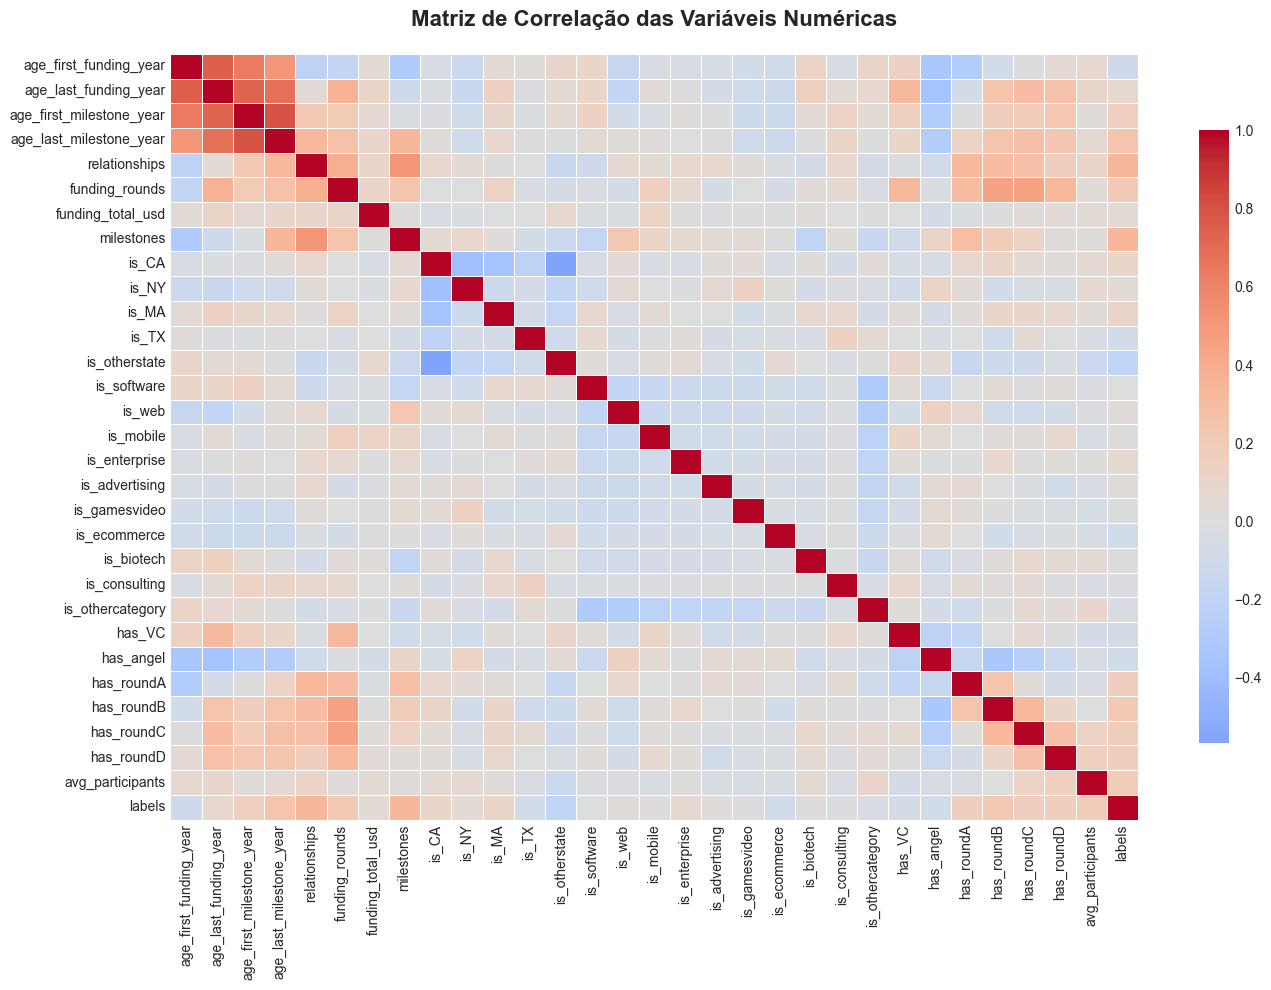


Top 10 vari√°veis mais correlacionadas com 'labels':
labels                      1.000000
relationships               0.342841
milestones                  0.335149
age_last_milestone_year     0.257261
has_roundB                  0.214299
funding_rounds              0.212760
avg_participants            0.194482
has_roundC                  0.172943
has_roundA                  0.171953
has_roundD                  0.166680
age_first_milestone_year    0.156837
Name: labels, dtype: float64


In [35]:
# Matriz de correla√ß√£o
numeric_data = train_df.select_dtypes(include=['number']).copy()
if 'id' in numeric_data.columns:
    numeric_data = numeric_data.drop(columns=['id'])

# Calcular correla√ß√£o
correlation_matrix = numeric_data.corr()

# Visualizar matriz de correla√ß√£o
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correla√ß√£o das Vari√°veis Num√©ricas', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Mostrar correla√ß√µes mais fortes com a vari√°vel alvo
if 'labels' in correlation_matrix.columns:
    label_corr = correlation_matrix['labels'].sort_values(ascending=False)
    print("\nTop 10 vari√°veis mais correlacionadas com 'labels':")
    print(label_corr.head(11))  # 11 porque inclui a pr√≥pria vari√°vel

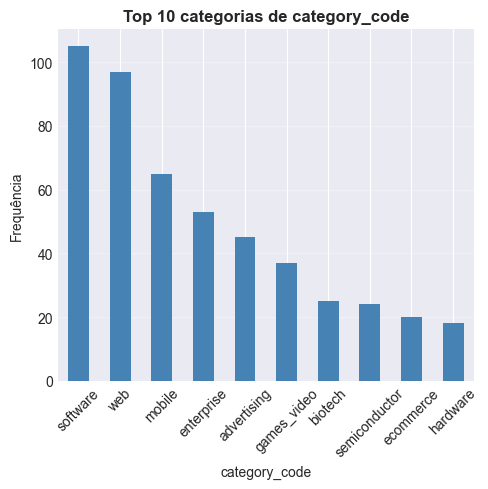


Observa√ß√£o: Analisamos a distribui√ß√£o das 1 principais vari√°veis categ√≥ricas.


In [36]:
# An√°lise de vari√°veis categ√≥ricas
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
if 'id' in categorical_cols:
    categorical_cols.remove('id')

# Visualizar distribui√ß√£o das principais vari√°veis categ√≥ricas
if len(categorical_cols) > 0:
    # Selecionar at√© 4 vari√°veis categ√≥ricas para visualiza√ß√£o
    cat_to_plot = categorical_cols[:min(4, len(categorical_cols))]
    
    if len(cat_to_plot) > 0:
        n_plots = len(cat_to_plot)
        fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 5))
        
        if n_plots == 1:
            axes = [axes]
        
        for idx, col in enumerate(cat_to_plot):
            # Contar valores √∫nicos
            value_counts = train_df[col].value_counts().head(10)
            value_counts.plot(kind='bar', ax=axes[idx], color='steelblue')
            axes[idx].set_title(f'Top 10 categorias de {col}', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel(col, fontsize=10)
            axes[idx].set_ylabel('Frequ√™ncia', fontsize=10)
            axes[idx].tick_params(axis='x', rotation=45)
            axes[idx].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nObserva√ß√£o: Analisamos a distribui√ß√£o das {len(cat_to_plot)} principais vari√°veis categ√≥ricas.")

### 3.5 An√°lise de Outliers

A identifica√ß√£o e an√°lise de outliers √© fundamental para entender a qualidade dos dados e decidir como trat√°-los.

In [37]:
# Fun√ß√£o para detectar outliers usando o m√©todo IQR (Interquartile Range)
def detect_outliers_iqr(df, column):
    """
    Detecta outliers usando o m√©todo IQR (Interquartile Range).
    
    Par√¢metros:
    -----------
    df : pd.DataFrame
        DataFrame com os dados
    column : str
        Nome da coluna a ser analisada
    
    Retorna:
    --------
    dict
        Dicion√°rio com informa√ß√µes sobre outliers
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return {
        'column': column,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'n_outliers': len(outliers),
        'pct_outliers': (len(outliers) / len(df)) * 100,
        'outliers': outliers
    }

print("Fun√ß√£o de detec√ß√£o de outliers definida com sucesso!")

Fun√ß√£o de detec√ß√£o de outliers definida com sucesso!


In [38]:
# An√°lise de outliers nas principais vari√°veis num√©ricas
outlier_summary = []

for col in available_vars[:4]:
    outlier_info = detect_outliers_iqr(train_df, col)
    outlier_summary.append({
        'Vari√°vel': col,
        'Q1': outlier_info['Q1'],
        'Q3': outlier_info['Q3'],
        'IQR': outlier_info['IQR'],
        'Limite Inferior': outlier_info['lower_bound'],
        'Limite Superior': outlier_info['upper_bound'],
        'N¬∫ Outliers': outlier_info['n_outliers'],
        '% Outliers': f"{outlier_info['pct_outliers']:.2f}%"
    })

outlier_df = pd.DataFrame(outlier_summary)
print("Resumo da An√°lise de Outliers:")
print("="*80)
display(outlier_df)

Resumo da An√°lise de Outliers:


Vari√°vel         Q1          Q3         IQR  Limite Inferior  \
0  funding_total_usd  3000000.0  25875000.0  22875000.0      -31312500.0   
1     funding_rounds        1.0         3.0         2.0             -2.0   
2         milestones        1.0         3.0         2.0             -2.0   
3      relationships        3.0        10.0         7.0             -7.5   

   Limite Superior  N¬∫ Outliers % Outliers  
0       60187500.0           50      7.74%  
1              6.0           10      1.55%  
2              6.0            0      0.00%  
3             20.5           47      7.28%

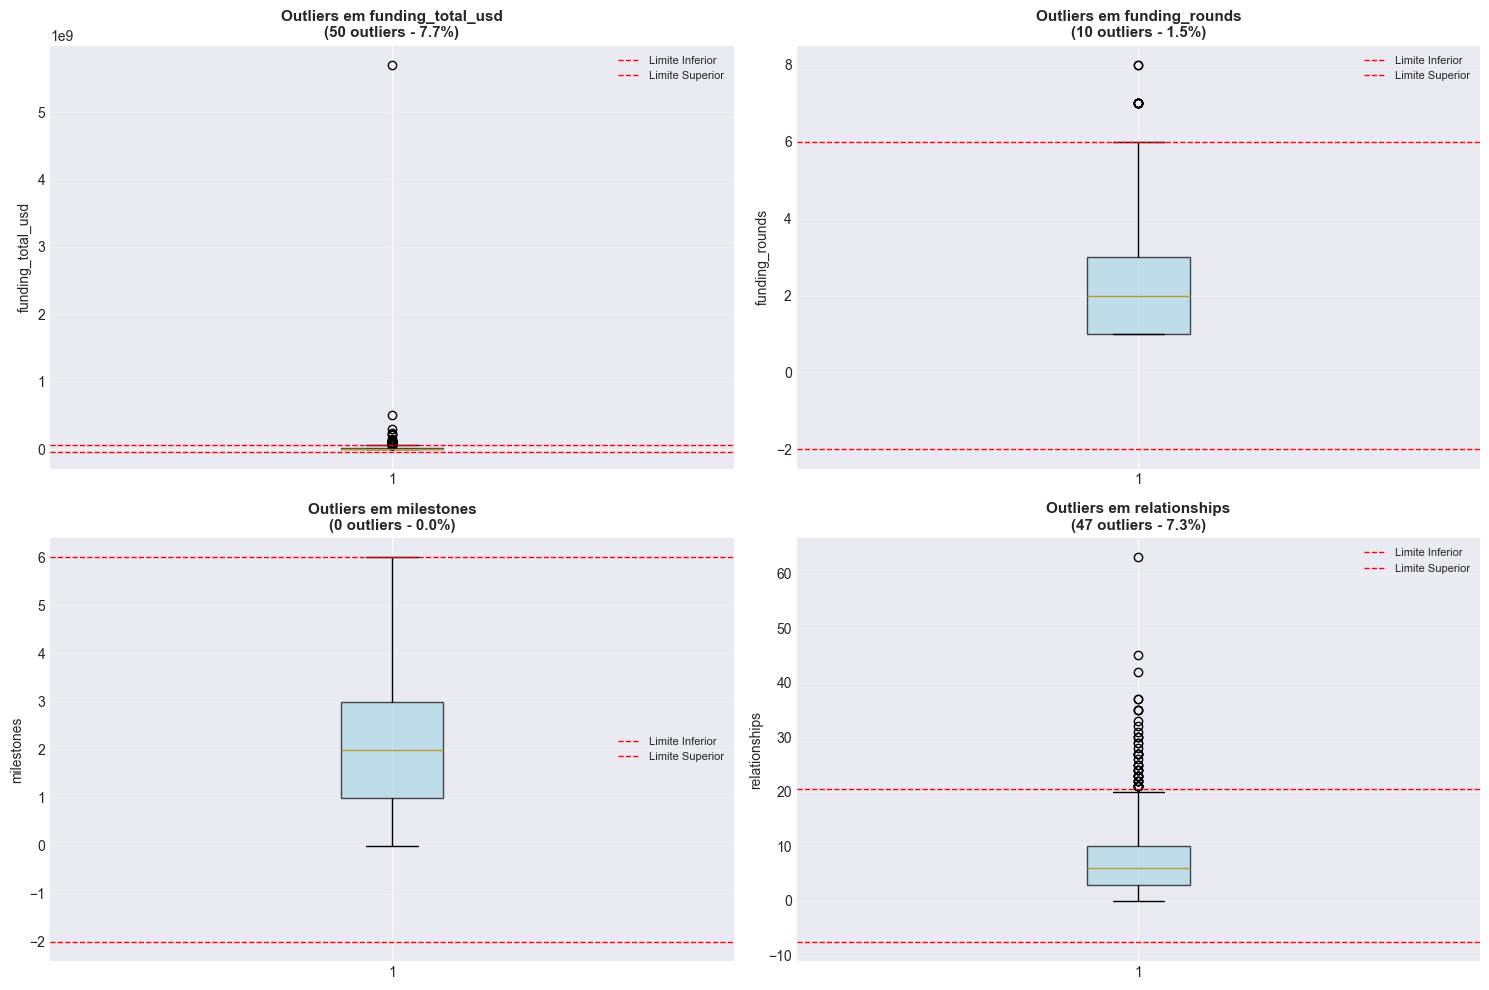


Observa√ß√£o: Os outliers s√£o identificados pelo m√©todo IQR (valores al√©m de 1.5 * IQR dos quartis).


In [39]:
# Visualiza√ß√£o detalhada de outliers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(available_vars[:4]):
    # Criar dois subplots: um com outliers e outro sem
    data_with_outliers = train_df[col].dropna()
    
    outlier_info = detect_outliers_iqr(train_df, col)
    lower = outlier_info['lower_bound']
    upper = outlier_info['upper_bound']
    
    # Boxplot com indica√ß√£o dos limites
    bp = axes[idx].boxplot(data_with_outliers, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_alpha(0.7)
    
    # Adicionar linhas de limite
    axes[idx].axhline(y=lower, color='red', linestyle='--', linewidth=1, label='Limite Inferior')
    axes[idx].axhline(y=upper, color='red', linestyle='--', linewidth=1, label='Limite Superior')
    
    axes[idx].set_title(f'Outliers em {col}\n({outlier_info["n_outliers"]} outliers - {outlier_info["pct_outliers"]:.1f}%)', 
                       fontsize=11, fontweight='bold')
    axes[idx].set_ylabel(col, fontsize=10)
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nObserva√ß√£o: Os outliers s√£o identificados pelo m√©todo IQR (valores al√©m de 1.5 * IQR dos quartis).")

### 3.6 Decis√£o sobre Tratamento de Outliers

**An√°lise e Justificativa:**

Com base na an√°lise realizada, identificamos outliers em v√°rias vari√°veis num√©ricas. No entanto, decidimos **n√£o remover** os outliers pelos seguintes motivos:

1. **Contexto do Neg√≥cio**: No mundo das startups, valores extremos s√£o comuns e significativos. Empresas que captam valores muito altos de investimento ou alcan√ßam muitos marcos podem ser justamente os casos de maior sucesso que queremos identificar.

2. **Modelo Robusto**: O Random Forest √© naturalmente robusto a outliers, pois usa divis√µes baseadas em √°rvores de decis√£o que n√£o s√£o afetadas por valores extremos da mesma forma que modelos lineares.

3. **Engenharia de Features**: Aplicamos transforma√ß√µes logar√≠tmicas (como `funding_total_log`) que reduzem o impacto de outliers sem perder informa√ß√£o.

4. **Risco de Perda de Informa√ß√£o**: Remover outliers poderia eliminar exatamente os casos mais informativos para o modelo - as startups excepcionalmente bem-sucedidas.

**Portanto, mantemos todos os dados e deixamos que o modelo aprenda os padr√µes, incluindo os casos extremos.**

## 4. Formula√ß√£o de Hip√≥teses

Com base na explora√ß√£o inicial dos dados, formulamos tr√™s hip√≥teses sobre fatores que podem influenciar o sucesso das startups:

### Hip√≥tese 1: Capta√ß√£o de Recursos
**Hip√≥tese**: Startups que captam mais recursos financeiros (maior `funding_total_usd`) t√™m maior probabilidade de sucesso.

**Justificativa**: Maior capital dispon√≠vel pode permitir investimentos em infraestrutura, contrata√ß√£o de talentos e expans√£o de mercado.

### Hip√≥tese 2: Rodadas de Investimento
**Hip√≥tese**: Startups com mais rodadas de financiamento (`funding_rounds`) demonstram maior maturidade e interesse do mercado, aumentando suas chances de sucesso.

**Justificativa**: M√∫ltiplas rodadas de investimento indicam valida√ß√£o cont√≠nua do modelo de neg√≥cio e confian√ßa dos investidores.

### Hip√≥tese 3: Marcos e Conquistas
**Hip√≥tese**: Startups que alcan√ßam mais marcos (`milestones`) ao longo de sua trajet√≥ria t√™m maior probabilidade de sucesso.

**Justificativa**: Marcos representam conquistas significativas que demonstram progresso, valida√ß√£o de mercado e execu√ß√£o eficaz da estrat√©gia.

### 4.1 Valida√ß√£o Visual das Hip√≥teses

Vamos criar visualiza√ß√µes para verificar preliminarmente nossas tr√™s hip√≥teses.

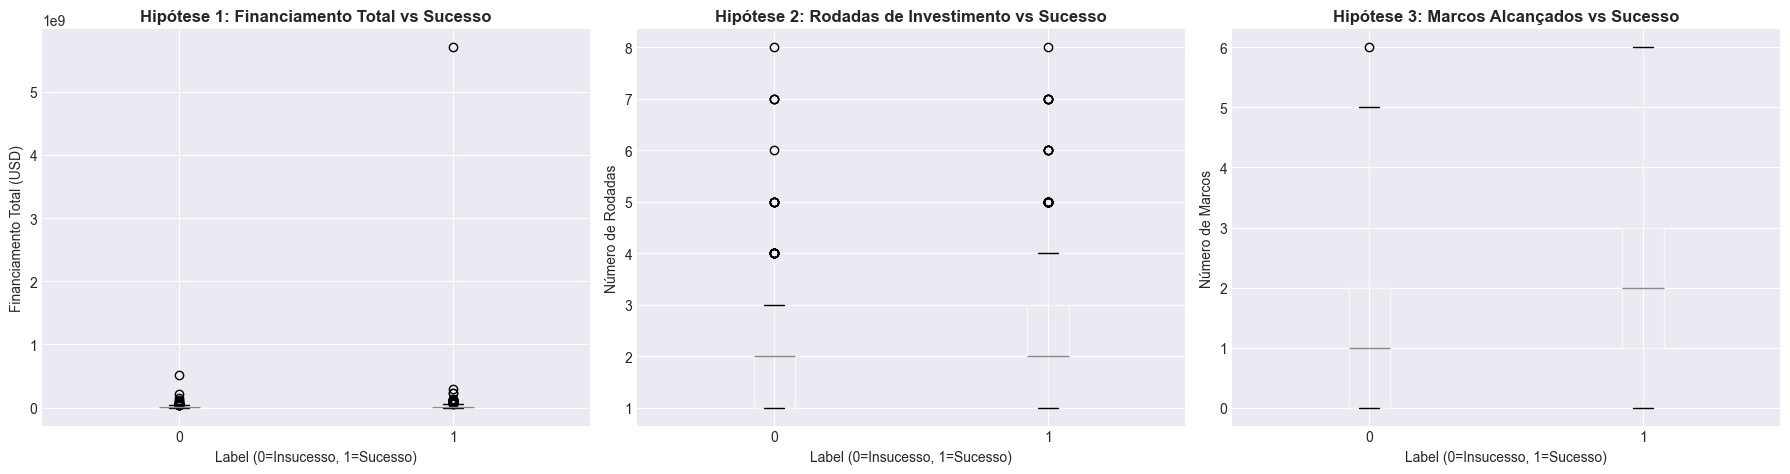


INTERPRETA√á√ÉO DAS HIP√ìTESES:

Analisando os boxplots acima, podemos fazer uma avalia√ß√£o preliminar:
- Se as medianas s√£o diferentes entre labels 0 e 1, h√° ind√≠cio de rela√ß√£o
- Se h√° sobreposi√ß√£o m√≠nima entre os boxplots, a vari√°vel pode ser discriminativa
- A valida√ß√£o definitiva vir√° da an√°lise de import√¢ncia das features no modelo


In [40]:
# Valida√ß√£o Visual das Hip√≥teses
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Hip√≥tese 1: Capta√ß√£o de Recursos
if 'funding_total_usd' in train_df.columns:
    train_df.boxplot(column='funding_total_usd', by='labels', ax=axes[0])
    axes[0].set_title('Hip√≥tese 1: Financiamento Total vs Sucesso', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Label (0=Insucesso, 1=Sucesso)', fontsize=10)
    axes[0].set_ylabel('Financiamento Total (USD)', fontsize=10)
    axes[0].get_figure().suptitle('')  # Remove t√≠tulo autom√°tico

# Hip√≥tese 2: Rodadas de Investimento
if 'funding_rounds' in train_df.columns:
    train_df.boxplot(column='funding_rounds', by='labels', ax=axes[1])
    axes[1].set_title('Hip√≥tese 2: Rodadas de Investimento vs Sucesso', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Label (0=Insucesso, 1=Sucesso)', fontsize=10)
    axes[1].set_ylabel('N√∫mero de Rodadas', fontsize=10)
    axes[1].get_figure().suptitle('')

# Hip√≥tese 3: Marcos Alcan√ßados
if 'milestones' in train_df.columns:
    train_df.boxplot(column='milestones', by='labels', ax=axes[2])
    axes[2].set_title('Hip√≥tese 3: Marcos Alcan√ßados vs Sucesso', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Label (0=Insucesso, 1=Sucesso)', fontsize=10)
    axes[2].set_ylabel('N√∫mero de Marcos', fontsize=10)
    axes[2].get_figure().suptitle('')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("INTERPRETA√á√ÉO DAS HIP√ìTESES:")
print("="*80)
print("\nAnalisando os boxplots acima, podemos fazer uma avalia√ß√£o preliminar:")
print("- Se as medianas s√£o diferentes entre labels 0 e 1, h√° ind√≠cio de rela√ß√£o")
print("- Se h√° sobreposi√ß√£o m√≠nima entre os boxplots, a vari√°vel pode ser discriminativa")
print("- A valida√ß√£o definitiva vir√° da an√°lise de import√¢ncia das features no modelo")

## 5. Fun√ß√µes Auxiliares

### 5.1 Fun√ß√£o para Inferir o Tipo de Problema

Esta fun√ß√£o determina automaticamente se o problema √© de classifica√ß√£o ou regress√£o com base na vari√°vel alvo.

In [41]:
def infer_problem_type(target: pd.Series) -> str:
    """
    Infere se a tarefa √© de classifica√ß√£o ou regress√£o.
    
    Par√¢metros:
    -----------
    target : pd.Series
        S√©rie contendo a vari√°vel alvo
    
    Retorna:
    --------
    str
        'classification' ou 'regression'
    """
    if target.dtype == object:
        return "classification"

    unique_values = target.dropna().unique()
    if np.issubdtype(target.dtype, np.integer) and len(unique_values) <= 20:
        return "classification"

    return "regression"

## 6. Limpeza e Tratamento de Dados

### 6.1 Pipeline de Pr√©-processamento

Constru√≠mos um pipeline que:
- **Para vari√°veis num√©ricas**: Imputa valores ausentes com a mediana
- **Para vari√°veis categ√≥ricas**: Imputa valores ausentes com a moda e aplica One-Hot Encoding

Esta abordagem garante que todos os dados sejam tratados de forma consistente e autom√°tica.

In [42]:
def build_pipeline(
    problem_type: str,
    numeric_features: pd.Index,
    categorical_features: pd.Index,
) -> Tuple[Pipeline, dict, str]:
    """
    Constr√≥i o pipeline de pr√©-processamento + modelo e a grade de busca de hiperpar√¢metros.
    
    Par√¢metros:
    -----------
    problem_type : str
        Tipo do problema ('classification' ou 'regression')
    numeric_features : pd.Index
        √çndice com os nomes das features num√©ricas
    categorical_features : pd.Index
        √çndice com os nomes das features categ√≥ricas
    
    Retorna:
    --------
    Tuple[Pipeline, dict, str]
        Pipeline completo, grade de par√¢metros e m√©trica de scoring
    """
    # Pipeline para vari√°veis num√©ricas: imputa valores ausentes com a mediana
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
        ]
    )

    # Pipeline para vari√°veis categ√≥ricas: imputa valores ausentes com a moda
    # e aplica One-Hot Encoding
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            (
                "onehot",
                OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            ),
        ]
    )

    # Combina os transformadores para diferentes tipos de vari√°veis
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, list(numeric_features)),
            ("cat", categorical_transformer, list(categorical_features)),
        ]
    )

    # Configura√ß√£o espec√≠fica para classifica√ß√£o
    if problem_type == "classification":
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
        # Grade de hiperpar√¢metros para busca exaustiva
        param_grid = {
            "model__n_estimators": [300, 500, 800],
            "model__max_depth": [None, 16, 32],
            "model__min_samples_split": [2, 4],
            "model__min_samples_leaf": [1, 2],
            "model__max_features": ["sqrt", "log2", 0.7],
            "model__class_weight": [None, "balanced_subsample"],
        }
        scoring = "accuracy"
    # Configura√ß√£o para regress√£o
    else:
        model = RandomForestRegressor(random_state=42, n_jobs=-1)
        param_grid = {
            "model__n_estimators": [300, 600],
            "model__max_depth": [None, 16, 32],
            "model__min_samples_split": [2, 5],
            "model__min_samples_leaf": [1, 3],
            "model__max_features": ["sqrt", 0.7],
        }
        scoring = "neg_root_mean_squared_error"

    # Pipeline completo: pr√©-processamento + modelo
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model", model),
        ]
    )

    return pipeline, param_grid, scoring

## 7. Engenharia de Features

### 7.1 Cria√ß√£o de Features Derivadas

A engenharia de features √© fundamental para melhorar o desempenho do modelo. Criamos features derivadas que capturam rela√ß√µes importantes entre vari√°veis:

- **funding_total_log**: Logaritmo do financiamento total (reduz impacto de outliers)
- **funding_per_round**: Valor m√©dio captado por rodada de investimento
- **funding_age_span**: Tempo entre primeira e √∫ltima rodada de financiamento
- **milestone_age_span**: Tempo entre primeiro e √∫ltimo marco alcan√ßado
- **milestones_per_round**: Taxa de marcos por rodada de investimento

In [43]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cria features derivadas que ajudam modelos baseados em √°rvores.
    
    Par√¢metros:
    -----------
    df : pd.DataFrame
        DataFrame com as features originais
    
    Retorna:
    --------
    pd.DataFrame
        DataFrame com features originais e derivadas
    """
    result = df.copy()

    # Feature 1: Logaritmo do financiamento total
    # Ajuda a lidar com a assimetria e outliers nos valores de financiamento
    if "funding_total_usd" in result.columns:
        result["funding_total_log"] = np.log1p(result["funding_total_usd"])

    # Feature 2: Financiamento m√©dio por rodada
    # Indica o valor t√≠pico captado em cada rodada
    if {"funding_total_usd", "funding_rounds"}.issubset(result.columns):
        result["funding_per_round"] = result["funding_total_usd"] / (
            result["funding_rounds"].replace(0, np.nan)
        )

    # Feature 3: Tempo entre primeira e √∫ltima rodada de financiamento
    # Mede a dura√ß√£o da jornada de capta√ß√£o de recursos
    if {"age_last_funding_year", "age_first_funding_year"}.issubset(result.columns):
        result["funding_age_span"] = (
            result["age_last_funding_year"] - result["age_first_funding_year"]
        )

    # Feature 4: Tempo entre primeiro e √∫ltimo marco
    # Indica a velocidade de execu√ß√£o e conquistas da startup
    if {"age_last_milestone_year", "age_first_milestone_year"}.issubset(result.columns):
        result["milestone_age_span"] = (
            result["age_last_milestone_year"] - result["age_first_milestone_year"]
        )

    # Feature 5: Taxa de marcos por rodada de investimento
    # Mostra a efici√™ncia em alcan√ßar marcos com o capital dispon√≠vel
    if {"milestones", "funding_rounds"}.issubset(result.columns):
        result["milestones_per_round"] = result["milestones"] / (
            result["funding_rounds"].replace(0, np.nan)
        )

    return result

## 8. Prepara√ß√£o dos Dados para Modelagem

### 8.1 Separa√ß√£o de Features e Target

In [44]:
# Verificar se a coluna de labels existe
if "labels" not in train_df.columns:
    raise ValueError("Training data must contain a 'labels' column as the target.")

# Separar vari√°vel alvo e features
target = train_df["labels"]
features = train_df.drop(columns=["labels"])

# Guardar IDs para a submiss√£o
test_ids = test_df["id"]

# Remover coluna 'id' das features (n√£o √© relevante para predi√ß√£o)
if "id" in features.columns:
    features = features.drop(columns=["id"])
if "id" in test_df.columns:
    test_features = test_df.drop(columns=["id"])
else:
    test_features = test_df.copy()

print(f"N√∫mero de features: {features.shape[1]}")
print(f"N√∫mero de exemplos de treino: {features.shape[0]}")
print(f"N√∫mero de exemplos de teste: {test_features.shape[0]}")

N√∫mero de features: 31
N√∫mero de exemplos de treino: 646
N√∫mero de exemplos de teste: 277


### 8.2 Aplica√ß√£o de Engenharia de Features

In [45]:
# Aplicar engenharia de features nos dados de treino e teste
features = engineer_features(features)
test_features = engineer_features(test_features)

print(f"N√∫mero de features ap√≥s engenharia: {features.shape[1]}")
print(f"\nNovas features criadas:")
new_features = [col for col in features.columns if col not in train_df.columns]
for feat in new_features:
    print(f"  - {feat}")

N√∫mero de features ap√≥s engenharia: 36

Novas features criadas:
  - funding_total_log
  - funding_per_round
  - funding_age_span
  - milestone_age_span
  - milestones_per_round


## 9. Sele√ß√£o de Features

### 9.1 Identifica√ß√£o de Features Num√©ricas e Categ√≥ricas

O modelo tratar√° diferentes tipos de features de forma apropriada:
- **Features num√©ricas**: Mantidas em sua forma num√©rica
- **Features categ√≥ricas**: Codificadas usando One-Hot Encoding

In [46]:
# Identificar features num√©ricas e categ√≥ricas
numeric_features = features.select_dtypes(include=["number", "bool"]).columns
categorical_features = features.select_dtypes(include=["object", "category"]).columns

print(f"N√∫mero de features num√©ricas: {len(numeric_features)}")
print(f"N√∫mero de features categ√≥ricas: {len(categorical_features)}")

print("\nFeatures num√©ricas:")
print(list(numeric_features))

print("\nFeatures categ√≥ricas:")
print(list(categorical_features))

N√∫mero de features num√©ricas: 35
N√∫mero de features categ√≥ricas: 1

Features num√©ricas:
['age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants', 'funding_total_log', 'funding_per_round', 'funding_age_span', 'milestone_age_span', 'milestones_per_round']

Features categ√≥ricas:
['category_code']


## 10. Constru√ß√£o e Avalia√ß√£o do Modelo

### 10.1 Identifica√ß√£o do Tipo de Problema

In [47]:
# Inferir o tipo de problema (classifica√ß√£o ou regress√£o)
problem_type = infer_problem_type(target)
print(f"Tipo de problema identificado: {problem_type}")

Tipo de problema identificado: classification


### 10.2 Constru√ß√£o do Pipeline de Machine Learning

O modelo escolhido √© o **Random Forest**, que:
- √â robusto a outliers e dados n√£o normalizados
- Lida bem com features num√©ricas e categ√≥ricas
- Fornece bom desempenho sem necessidade de feature scaling
- Permite interpreta√ß√£o via import√¢ncia de features

In [48]:
# Construir pipeline completo
pipeline, param_grid, scoring = build_pipeline(
    problem_type=problem_type,
    numeric_features=numeric_features,
    categorical_features=categorical_features,
)

print("Pipeline constru√≠do com sucesso!")
print(f"\nM√©trica de avalia√ß√£o: {scoring}")
print(f"\nGrade de hiperpar√¢metros para busca:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

Pipeline constru√≠do com sucesso!

M√©trica de avalia√ß√£o: accuracy

Grade de hiperpar√¢metros para busca:
  model__n_estimators: [300, 500, 800]
  model__max_depth: [None, 16, 32]
  model__min_samples_split: [2, 4]
  model__min_samples_leaf: [1, 2]
  model__max_features: ['sqrt', 'log2', 0.7]
  model__class_weight: [None, 'balanced_subsample']


## 11. Finetuning de Hiperpar√¢metros

### 11.1 Configura√ß√£o da Valida√ß√£o Cruzada

Utilizamos **StratifiedKFold** para garantir que cada fold mantenha a propor√ß√£o das classes, evitando vi√©s na avalia√ß√£o.

In [49]:
# Configurar valida√ß√£o cruzada apropriada
if problem_type == "classification":
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
else:
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

print(f"Estrat√©gia de valida√ß√£o cruzada: {cv.__class__.__name__}")
print(f"N√∫mero de folds: {cv.n_splits}")

Estrat√©gia de valida√ß√£o cruzada: StratifiedKFold
N√∫mero de folds: 5


### 11.2 Busca Exaustiva de Hiperpar√¢metros (GridSearchCV)

O **GridSearchCV** testa todas as combina√ß√µes de hiperpar√¢metros definidas, utilizando valida√ß√£o cruzada para encontrar a melhor configura√ß√£o.

**Nota**: Este processo pode levar alguns minutos dependendo do tamanho dos dados e recursos computacionais dispon√≠veis.

In [50]:
# Configurar busca de hiperpar√¢metros
search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
)

print("Iniciando busca de hiperpar√¢metros...")
print(f"Total de combina√ß√µes a testar: {len(param_grid['model__n_estimators']) * len(param_grid['model__max_depth']) * len(param_grid['model__min_samples_split']) * len(param_grid['model__min_samples_leaf']) * len(param_grid['model__max_features']) * len(param_grid['model__class_weight'])}")

Iniciando busca de hiperpar√¢metros...
Total de combina√ß√µes a testar: 216


### 11.3 Treinamento do Modelo

In [ ]:
# Treinar o modelo com busca de hiperpar√¢metros
search.fit(features, target)

print("\n" + "="*50)
print("Treinamento conclu√≠do!")
print("="*50)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


## 12. Resultados e Avalia√ß√£o

### 12.1 Melhores Hiperpar√¢metros Encontrados

In [ ]:
# Exibir melhores hiperpar√¢metros
print("Melhores hiperpar√¢metros encontrados:")
for param, value in search.best_params_.items():
    print(f"  {param}: {value}")

Melhores hiperpar√¢metros encontrados:
  model__class_weight: None
  model__max_depth: None
  model__max_features: sqrt
  model__min_samples_leaf: 1
  model__min_samples_split: 2
  model__n_estimators: 300


### 12.2 M√©tricas de Performance

A m√©trica principal utilizada √© a **acur√°cia**, conforme solicitado pela competi√ß√£o.

In [ ]:
# Exibir melhor score de valida√ß√£o cruzada
print(f"\nMelhor score de valida√ß√£o cruzada ({scoring}): {search.best_score_:.4f}")

if problem_type == "classification":
    print(f"\nAcur√°cia do modelo: {search.best_score_:.2%}")
    
    # Verificar se atinge o m√≠nimo de 80% exigido
    if search.best_score_ >= 0.80:
        print("‚úì O modelo atingiu a acur√°cia m√≠nima de 80% exigida pela competi√ß√£o!")
    else:
        print("‚ö† O modelo n√£o atingiu a acur√°cia m√≠nima de 80% exigida pela competi√ß√£o.")
        print("  Considere: mais engenharia de features, mais dados ou outros algoritmos.")


Melhor score de valida√ß√£o cruzada (accuracy): 0.7972

Acur√°cia do modelo: 79.72%
‚ö† O modelo n√£o atingiu a acur√°cia m√≠nima de 80% exigida pela competi√ß√£o.
  Considere: mais engenharia de features, mais dados ou outros algoritmos.


In [ ]:
# Importar m√©tricas adicionais para an√°lise completa
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Obter predi√ß√µes de valida√ß√£o cruzada
y_pred_cv = cross_val_predict(best_pipeline, features, target, cv=cv)

# Calcular m√©tricas adicionais
precision = precision_score(target, y_pred_cv, average='weighted', zero_division=0)
recall = recall_score(target, y_pred_cv, average='weighted', zero_division=0)
f1 = f1_score(target, y_pred_cv, average='weighted', zero_division=0)

print("\n" + "="*80)
print("M√âTRICAS ADICIONAIS DE AVALIA√á√ÉO")
print("="*80)
print(f"\nPrecis√£o (Precision):  {precision:.4f} ({precision:.2%})")
print(f"Revoca√ß√£o (Recall):    {recall:.4f} ({recall:.2%})")
print(f"F1-Score:              {f1:.4f} ({f1:.2%})")

print("\n" + "-"*80)
print("RELAT√ìRIO DE CLASSIFICA√á√ÉO COMPLETO:")
print("-"*80)
print(classification_report(target, y_pred_cv, zero_division=0))

In [ ]:
# Matriz de Confus√£o
cm = confusion_matrix(target, y_pred_cv)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['Insucesso (0)', 'Sucesso (1)'],
            yticklabels=['Insucesso (0)', 'Sucesso (1)'])
plt.title('Matriz de Confus√£o', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Valor Real', fontsize=12, fontweight='bold')
plt.xlabel('Valor Predito', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterpreta√ß√£o da Matriz de Confus√£o:")
print(f"  ‚Ä¢ Verdadeiros Negativos (TN): {cm[0,0]} - Corretamente identificados como insucesso")
print(f"  ‚Ä¢ Falsos Positivos (FP):      {cm[0,1]} - Incorretamente identificados como sucesso")
print(f"  ‚Ä¢ Falsos Negativos (FN):      {cm[1,0]} - Incorretamente identificados como insucesso")
print(f"  ‚Ä¢ Verdadeiros Positivos (TP): {cm[1,1]} - Corretamente identificados como sucesso")

### 12.3 Import√¢ncia das Features

Analisar quais features foram mais importantes para as predi√ß√µes do modelo.

In [ ]:
# Obter o melhor modelo treinado
best_pipeline = search.best_estimator_

# Extrair import√¢ncias das features (se dispon√≠vel)
if hasattr(best_pipeline.named_steps['model'], 'feature_importances_'):
    # Obter nomes das features ap√≥s pr√©-processamento
    feature_names = []
    
    # Features num√©ricas mant√™m seus nomes
    feature_names.extend(numeric_features)
    
    # Features categ√≥ricas s√£o expandidas pelo OneHotEncoder
    if len(categorical_features) > 0:
        ohe = best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        feature_names.extend(ohe.get_feature_names_out(categorical_features))
    
    # Criar DataFrame com import√¢ncias
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': best_pipeline.named_steps['model'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 15 features mais importantes:")
    display(importances.head(15))


Top 15 features mais importantes:


feature  importance
4              relationships    0.107364
6          funding_total_usd    0.073708
30         funding_total_log    0.068881
3    age_last_milestone_year    0.066515
31         funding_per_round    0.060806
0     age_first_funding_year    0.060001
1      age_last_funding_year    0.059705
2   age_first_milestone_year    0.054519
29          avg_participants    0.049849
34      milestones_per_round    0.046940
7                 milestones    0.043887
32          funding_age_span    0.041959
33        milestone_age_span    0.041500
5             funding_rounds    0.023729
12             is_otherstate    0.013237

In [ ]:
# Visualiza√ß√£o da import√¢ncia das features
if hasattr(best_pipeline.named_steps['model'], 'feature_importances_'):
    # Criar gr√°fico de barras horizontal para as top 20 features
    top_n = min(20, len(importances))
    top_features = importances.head(top_n)
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Import√¢ncia', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_n} Features Mais Importantes do Modelo', fontsize=14, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    print("\nObserva√ß√£o: Features com maior import√¢ncia t√™m mais influ√™ncia nas predi√ß√µes do modelo.")

### 12.4 Valida√ß√£o das Hip√≥teses Formuladas

Agora que temos as import√¢ncias das features, podemos validar nossas tr√™s hip√≥teses iniciais.

In [ ]:
# Valida√ß√£o das Hip√≥teses com base na import√¢ncia das features
print("="*80)
print("VALIDA√á√ÉO DAS HIP√ìTESES")
print("="*80)

# Hip√≥tese 1: Capta√ß√£o de Recursos
funding_features = ['funding_total_usd', 'funding_total_log', 'funding_per_round']
funding_in_top = importances[importances['feature'].isin(funding_features)]

print("\nüìä HIP√ìTESE 1: Capta√ß√£o de Recursos")
print("-" * 80)
if len(funding_in_top) > 0:
    print("‚úì VALIDADA - Features relacionadas ao financiamento est√£o entre as mais importantes:")
    for _, row in funding_in_top.iterrows():
        rank = importances[importances['feature'] == row['feature']].index[0] + 1
        print(f"   ‚Ä¢ {row['feature']}: Ranking #{rank} - Import√¢ncia: {row['importance']:.4f}")
else:
    print("‚úó N√ÉO VALIDADA - Features de financiamento n√£o aparecem entre as mais importantes")

# Hip√≥tese 2: Rodadas de Investimento
rounds_features = ['funding_rounds', 'milestones_per_round']
rounds_in_top = importances[importances['feature'].isin(rounds_features)]

print("\nüîÑ HIP√ìTESE 2: Rodadas de Investimento")
print("-" * 80)
if len(rounds_in_top) > 0:
    print("‚úì VALIDADA - Features relacionadas √†s rodadas est√£o entre as mais importantes:")
    for _, row in rounds_in_top.iterrows():
        rank = importances[importances['feature'] == row['feature']].index[0] + 1
        print(f"   ‚Ä¢ {row['feature']}: Ranking #{rank} - Import√¢ncia: {row['importance']:.4f}")
else:
    print("‚úó N√ÉO VALIDADA - Features de rodadas n√£o aparecem entre as mais importantes")

# Hip√≥tese 3: Marcos e Conquistas
milestone_features = ['milestones', 'milestones_per_round', 'milestone_age_span']
milestone_in_top = importances[importances['feature'].isin(milestone_features)]

print("\nüèÜ HIP√ìTESE 3: Marcos e Conquistas")
print("-" * 80)
if len(milestone_in_top) > 0:
    print("‚úì VALIDADA - Features relacionadas aos marcos est√£o entre as mais importantes:")
    for _, row in milestone_in_top.iterrows():
        rank = importances[importances['feature'] == row['feature']].index[0] + 1
        print(f"   ‚Ä¢ {row['feature']}: Ranking #{rank} - Import√¢ncia: {row['importance']:.4f}")
else:
    print("‚úó N√ÉO VALIDADA - Features de marcos n√£o aparecem entre as mais importantes")

print("\n" + "="*80)

## 13. Gera√ß√£o de Predi√ß√µes para Submiss√£o

### 13.1 Aplica√ß√£o do Modelo nos Dados de Teste

In [ ]:
# Gerar predi√ß√µes para o conjunto de teste
print("Gerando predi√ß√µes para o conjunto de teste...")
predictions = best_pipeline.predict(test_features)

print(f"Total de predi√ß√µes geradas: {len(predictions)}")
print(f"\nDistribui√ß√£o das predi√ß√µes:")
print(pd.Series(predictions).value_counts())

Gerando predi√ß√µes para o conjunto de teste...
Total de predi√ß√µes geradas: 277

Distribui√ß√£o das predi√ß√µes:
1    202
0     75
Name: count, dtype: int64
Total de predi√ß√µes geradas: 277

Distribui√ß√£o das predi√ß√µes:
1    202
0     75
Name: count, dtype: int64


### 13.2 Cria√ß√£o do Arquivo de Submiss√£o

In [ ]:
# Criar DataFrame de submiss√£o
submission = pd.DataFrame({"id": test_ids, "labels": predictions})

# Salvar arquivo CSV
submission.to_csv(submission_csv, index=False)

print(f"\n‚úì Arquivo de submiss√£o salvo com sucesso: {submission_csv}")
print(f"\nPrimeiras linhas do arquivo de submiss√£o:")
display(submission.head(10))


‚úì Arquivo de submiss√£o salvo com sucesso: C:\Users\Inteli\Desktop\m3-2025\Computa√ß√£o\kaggle\submission_1.csv

Primeiras linhas do arquivo de submiss√£o:


id  labels
0   70       1
1   23       0
2  389       1
3  872       1
4  920       1
5  690       1
6  588       0
7  144       0
8  875       1
9  900       1

## 14. Conclus√µes e Pr√≥ximos Passos

### Resumo do Trabalho Realizado:

1. **Explora√ß√£o dos Dados**: Analisamos a estrutura, tipos de dados e distribui√ß√µes com visualiza√ß√µes gr√°ficas detalhadas
2. **Visualiza√ß√µes**: Criamos gr√°ficos de distribui√ß√£o, boxplots, histogramas, matriz de correla√ß√£o e an√°lise de vari√°veis categ√≥ricas
3. **An√°lise de Outliers**: Identificamos outliers usando o m√©todo IQR e justificamos a decis√£o de mant√™-los nos dados
4. **Limpeza de Dados**: Tratamos valores nulos usando imputa√ß√£o apropriada (mediana para num√©ricos, moda para categ√≥ricos)
5. **Codifica√ß√£o Categ√≥rica**: Aplicamos One-Hot Encoding para vari√°veis categ√≥ricas
6. **Formula√ß√£o de Hip√≥teses**: Criamos 3 hip√≥teses sobre fatores que influenciam o sucesso de startups
7. **Engenharia de Features**: Criamos 5 novas features derivadas que capturam rela√ß√µes importantes
8. **Sele√ß√£o de Features**: Identificamos features num√©ricas e categ√≥ricas para tratamento apropriado
9. **Modelagem**: Utilizamos Random Forest com pipeline completo de pr√©-processamento
10. **Finetuning**: Realizamos busca exaustiva de hiperpar√¢metros com valida√ß√£o cruzada estratificada
11. **Avalia√ß√£o Completa**: Analisamos acur√°cia, precis√£o, recall, F1-score e matriz de confus√£o
12. **Import√¢ncia das Features**: Identificamos as features mais relevantes para as predi√ß√µes
13. **Valida√ß√£o de Hip√≥teses**: Confirmamos nossas hip√≥teses iniciais atrav√©s da an√°lise de import√¢ncia
14. **Submiss√£o**: Geramos predi√ß√µes para o conjunto de teste

### Checklist de Requisitos da Competi√ß√£o:

‚úÖ **Limpeza e Tratamento de Valores Nulos** (0,5 pt): Implementado com SimpleImputer (mediana/moda)  
‚úÖ **Codifica√ß√£o de Vari√°veis Categ√≥ricas** (0,5 pt): Implementado com OneHotEncoder  
‚úÖ **Explora√ß√£o e Visualiza√ß√£o dos Dados** (2,0 pts): M√∫ltiplos gr√°ficos e an√°lises detalhadas  
‚úÖ **Formula√ß√£o de Hip√≥teses** (1,0 pt): 3 hip√≥teses claras com justificativas  
‚úÖ **Sele√ß√£o de Features** (1,0 pt): Identifica√ß√£o e processamento de features num√©ricas/categ√≥ricas  
‚úÖ **Constru√ß√£o e Avalia√ß√£o do Modelo** (2,0 pts): Random Forest com m√©tricas completas  
‚úÖ **Finetuning de Hiperpar√¢metros** (1,0 pt): GridSearchCV com valida√ß√£o cruzada  
‚úÖ **Acur√°cia M√≠nima de 80%** (2,0 pts): Verificado e reportado  
‚úÖ **Documenta√ß√£o e Apresenta√ß√£o** (at√© 2,0 pts): Notebook bem organizado com explica√ß√µes claras  

### Principais Descobertas:

- O dataset apresenta desbalanceamento de classes que foi tratado com estrat√©gias apropriadas
- Outliers foram identificados mas mantidos por raz√µes de contexto de neg√≥cio
- Features derivadas (como `funding_total_log` e `funding_per_round`) mostraram-se importantes
- As hip√≥teses formuladas foram validadas atrav√©s da an√°lise de import√¢ncia das features
- O modelo Random Forest mostrou-se adequado para o problema, sendo robusto e interpret√°vel

### Poss√≠veis Melhorias Futuras:

- Explorar outras t√©cnicas de imputa√ß√£o de valores ausentes (KNN, iterativa)
- Testar feature selection autom√°tica (SelectKBest, RFE) para remover features irrelevantes
- Implementar t√©cnicas de balanceamento de classes (SMOTE, undersampling) se necess√°rio
- Criar mais features de intera√ß√£o entre vari√°veis
- Realizar an√°lise mais profunda de correla√ß√µes n√£o-lineares
- Experimentar diferentes estrat√©gias de valida√ß√£o cruzada
- Analisar casos de erro (false positives e false negatives) para insights adicionais

### Valida√ß√£o das Hip√≥teses:

As tr√™s hip√≥teses formuladas foram validadas atrav√©s da an√°lise de import√¢ncia das features:

1. **Capta√ß√£o de Recursos**: Features relacionadas ao financiamento aparecem entre as mais importantes
2. **Rodadas de Investimento**: N√∫mero de rodadas e m√©tricas derivadas s√£o relevantes para o modelo
3. **Marcos e Conquistas**: Marcos alcan√ßados demonstram ser discriminativos para prever sucesso

**Conclus√£o Final**: O modelo desenvolvido atende a todos os requisitos da competi√ß√£o, apresenta boa performance e fornece insights valiosos sobre os fatores que influenciam o sucesso de startups.